In [1]:
import os.path as ops
import imageio as imageio
import numpy as np
import torch
import cv2
import os
import matplotlib.pylab as plt
import sys
sys.path.append('..')
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding, video_to_clips

# Load the Model

In [2]:
model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_22_batch_8.model'
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

# Load the Test Dataset

In [3]:
root = './TUSIMPLE/txt_for_local'
train_set = TUSIMPLE(root=root, flag='train')
valid_set = TUSIMPLE(root=root, flag='valid')
test_set = TUSIMPLE(root=root, flag='test')

print('train_set length {}'.format(len(train_set)))
print('valid_set length {}'.format(len(valid_set)))
print('test_set length {}'.format(len(test_set)))

train_set length 396
valid_set length 49
test_set length 50


In [4]:
gt, bgt, igt = test_set[20]
print('image type {}'.format(type(gt)))
print('image size {} \n'.format(gt.size()))

print('gt binary image type {}'.format(type(bgt)))
print('gt binary image size {}'.format(bgt.size()))
print('items in gt binary image {} \n'.format(torch.unique(bgt)))

print('gt instance type {}'.format(type(igt)))
print('gt instance size {}'.format(igt.size()))
print('items in gt instance {} \n'.format(torch.unique(igt)))

image type <class 'torch.Tensor'>
image size torch.Size([3, 256, 512]) 

gt binary image type <class 'torch.Tensor'>
gt binary image size torch.Size([256, 512])
items in gt binary image tensor([0, 1]) 

gt instance type <class 'torch.Tensor'>
gt instance size torch.Size([256, 512])
items in gt instance tensor([ 0, 20, 70]) 



In [5]:
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

# Get one output from the network

In [6]:
binary_final_logits, instance_embedding = LaneNet_model(gt.unsqueeze(0))
print('binary_final_logits shape: {}'.format(binary_final_logits.shape))
print('instance_embedding shape: {}'.format(instance_embedding.shape))

binary_final_logits shape: torch.Size([1, 2, 256, 512])
instance_embedding shape: torch.Size([1, 4, 256, 512])


# Show one result on Tset Dataset

### For ground truth

In [7]:
gt_image_show = ((gt.numpy() + 1) * 127.5).astype(int)

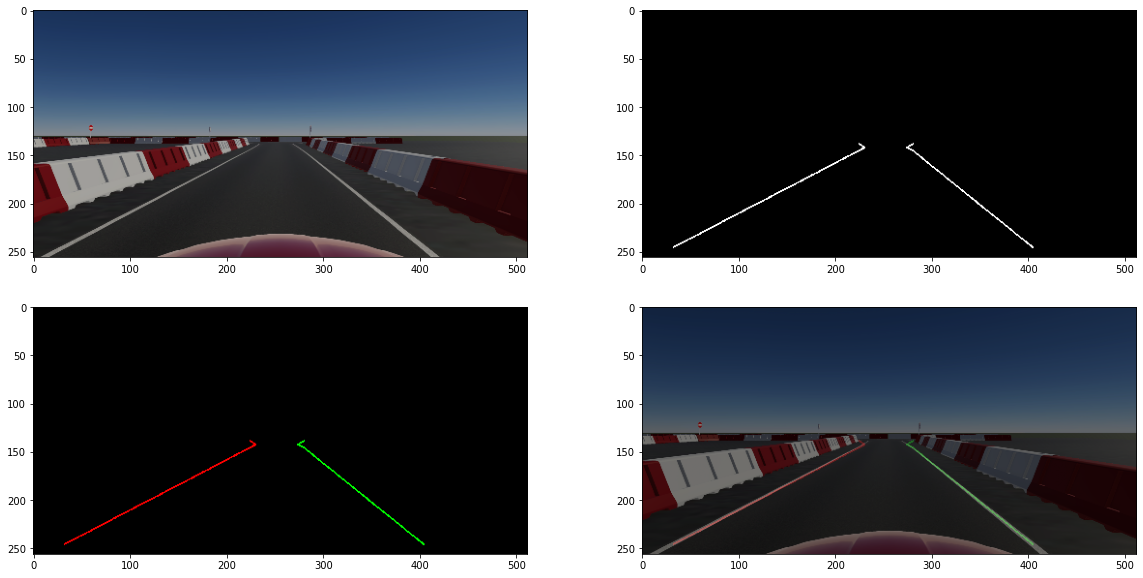

In [8]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
image_show = gt_image_show.transpose(1,2,0)
image_show = image_show[...,::-1]
plt.imshow(image_show)

ax1 = plt.subplot(222)
plt.imshow(bgt, cmap='gray')

ax1 = plt.subplot(223)
rbg_emb = gray_to_rgb_emb(igt)
plt.imshow(rbg_emb)

ax1 = plt.subplot(224)
a = 0.7
plt.imshow(a*image_show/255 + (1-a)*rbg_emb)

### For binary_final_logits

In [9]:
binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
# plt.imshow(binary_img, cmap='gray')

### For instance_embedding

In [10]:
rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img, distance=1, lane_num=5)

### Show result

Text(0.5, 1.0, 'Final result')

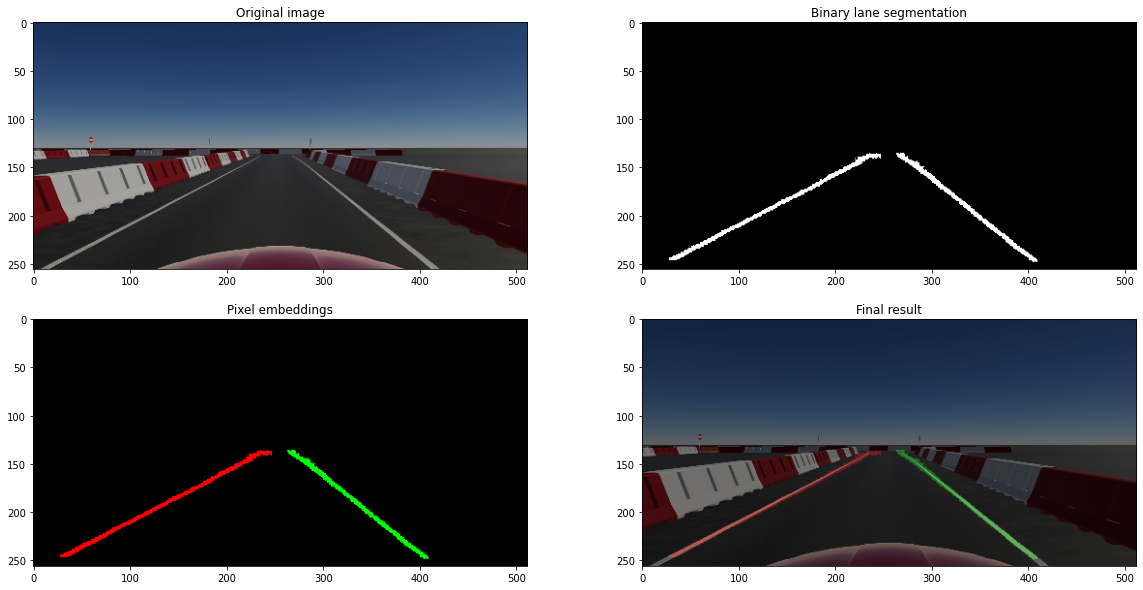

In [11]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
plt.imshow(image_show)
plt.title('Original image')

ax1 = plt.subplot(222)
plt.imshow(binary_img, cmap='gray')
plt.title('Binary lane segmentation')

ax1 = plt.subplot(223)
plt.imshow(rbg_emb)
plt.title('Pixel embeddings')

ax1 = plt.subplot(224)
a = 0.7
plt.imshow(a*image_show/255 + (1-a)*rbg_emb)
plt.title('Final result')

# Generate videos

In [19]:
### Read test_video.mp4 and make to clips

video_name = './TUSIMPLE/test_video/test_video.mp4'
video_to_clips(video_name)

### Read clips into dataset

In [12]:
# test_clips_root = '/Users/smiffy/Documents/GitHub/TUSIMPLE/test_video/clips'

In [16]:
def clips_to_gif(test_clips_root, git_root):
    img_paths = []
    for img_name in os.listdir(test_clips_root):
        img_paths.append(ops.join(test_clips_root,img_name))
    img_paths.sort()
    gif_frames = []
    for i, img_name in enumerate(img_paths):
        gt_img_org = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
        org_shape = gt_img_org.shape
        gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
        gt_image = gt_image / 127.5 - 1.0
        gt_image = torch.tensor(gt_image, dtype=torch.float)
        gt_image = np.transpose(gt_image, (2, 0, 1))

        binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
        binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
        binary_img[0:65,:] = 0
        rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img,
                                                             distance=1.5, lane_num=4)

        rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
        a = 0.6
        frame = a * gt_img_org[..., ::-1] / 255 + rbg_emb * (1 - a)
        frame = np.rint(frame * 255)
        frame = frame.astype(np.uint8)
        gif_frames.append(frame)
    imageio.mimsave(git_root, gif_frames, fps=5)

In [21]:
clips_root = './TUSIMPLE/train_set'
gif_dir = './TUSIMPLE/gif_output'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)
for dir_name in os.listdir(clips_root):
    print("yo")
    if dir_name == '.DS_Store':
        continue
    print('Pdrocess the clip {} \n'.format(dir_name))
    test_clips_root = ops.join(clips_root, dir_name)
    git_root = ops.join(gif_dir, dir_name) + '.gif'
    clips_to_gif(test_clips_root, git_root)

yo
Pdrocess the clip spark_data 



In [22]:
print("yo")

yo
